In [1]:
import torch
import pytorch_lightning as pl
import os
from training_scripts.sMNIST.model import rnn
from training_scripts.sMNIST.dataset import MnistDataModule
import training_scripts.sMNIST.default_config as config
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.profilers import PyTorchProfiler

torch.set_float32_matmul_precision("medium")

print("Number of CPUs available: ", torch.get_num_threads())

Number of CPUs available:  8


In [2]:
# Additional RNN cell configurations
# kwargs_dict = {
#     "Wr_identity": False,
#     "learn_tau": True,
#     "dt_tau_max_y": 0.05,
#     "dt_tau_max_a": 0.01,
#     "dt_tau_max_b": 0.1,
# }
kwargs_dict = {
    "Wr_identity": False,
    "learn_tau": True,
    "dt_tau_max_y": 0.05,
    "dt_tau_max_a": 0.01,
    "dt_tau_max_b": 0.1,
}

In [3]:
# change the accellerator to cpu for pixel by pixel mnist
# config.ACCELERATOR = "cpu"
# config.DEVICES = 1
config.RESIZE = 1.0
config.INPUT_SIZE = 1
config.SEQUENCE_LENGTH = 784
config.LEARNING_RATE = 0.01
config.ACCELERATOR = "gpu"
config.HIDDEN_SIZE = 64
config.BATCH_SIZE = 512

In [4]:
start_from_checkpoint = True
folder_name = "/vast/sr6364/dynamic-divisive-norm/tb_logs/rectified_input/sMNIST"
model_name = "sMNIST_64_0.05_0.01_0.1_lr_0.01_rectified_input"
logger = TensorBoardLogger(folder_name, name=model_name)
# profiler = PyTorchProfiler(
#     on_trace_ready=torch.profiler.tensorboard_trace_handler(f"{folder_name}/profiler0"),
#     schedule=torch.profiler.schedule(skip_first=10, wait=1, warmup=1, active=20),
# )
dm = MnistDataModule(
    data_dir=config.DATA_DIR,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    permuted=config.PERMUTED,
    resize=config.RESIZE,
)
model = rnn(
    input_size=config.INPUT_SIZE,
    hidden_size=config.HIDDEN_SIZE,
    seq_length=config.SEQUENCE_LENGTH,
    learning_rate=config.LEARNING_RATE,
    scheduler_change_step=config.SCHEDULER_CHANGE_STEP,
    scheduler_gamma=config.SCHEDULER_GAMMA,
    num_classes=config.NUM_CLASSES, 
    kwargs_dict=kwargs_dict,
)

In [5]:
model.org.Wr()

Parameter containing:
tensor([[-0.0823,  0.1139,  0.2195,  ..., -0.0910,  0.1019,  0.0808],
        [-0.0253, -0.0156, -0.1013,  ..., -0.0351,  0.1196,  0.1881],
        [ 0.0496, -0.0322, -0.0271,  ..., -0.1848,  0.0458, -0.1236],
        ...,
        [-0.0200,  0.1312, -0.1303,  ...,  0.1188,  0.0422, -0.0133],
        [ 0.0114, -0.0830, -0.1748,  ..., -0.0950,  0.1250, -0.2068],
        [-0.0537, -0.0983, -0.1394,  ...,  0.1472,  0.1702,  0.0146]],
       requires_grad=True)

In [6]:
trainer = pl.Trainer(
    profiler=None,
    logger=logger,
    accelerator=config.ACCELERATOR,
    callbacks=[LearningRateMonitor(logging_interval='epoch'),
               ModelCheckpoint(save_top_k=-1, every_n_epochs=1)],
    devices=config.DEVICES,
    min_epochs=1,
    max_epochs=10,
    precision=config.PRECISION
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
if start_from_checkpoint:
    version = 8
    epoch_no = None
    checkpoint_folder = f'{folder_name}/{model_name}/version_{version}/checkpoints/'
    checkpoint_files = os.listdir(checkpoint_folder)
    epoch_idx = [int(file.split('epoch=')[1].split('-')[0]) for file in checkpoint_files]
    if epoch_no is not None:
        # If epoch number is provided, find the index of that epoch
        max_idx = epoch_idx.index(epoch_no)
    else:
        # If epoch number is not provided, find the index of the max epoch
        max_idx = epoch_idx.index(max(epoch_idx))

    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_files[max_idx])
    trainer.fit(model, dm, ckpt_path=checkpoint_path)
else:
    trainer.fit(model, dm)

# trainer.validate(model, dm)
# trainer.test(model, dm)

Restoring states from the checkpoint path at /vast/sr6364/dynamic-divisive-norm/tb_logs/rectified_input/sMNIST/sMNIST_64_0.05_0.01_0.1_lr_0.01_rectified_input/version_8/checkpoints/epoch=0-step=223.ckpt
/ext3/miniconda3/envs/feed-r-conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:347: The dirpath has changed from '/vast/sr6364/dynamic-divisive-norm/tb_logs/rectified_input/sMNIST/sMNIST_64_0.05_0.01_0.1_lr_0.01_rectified_input/version_8/checkpoints' to '/vast/sr6364/dynamic-divisive-norm/tb_logs/rectified_input/sMNIST/sMNIST_64_0.05_0.01_0.1_lr_0.01_rectified_input/version_9/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | org      | rnnCell            | 25.1 K
1 | fc       | Linear        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: torch.linalg.eig: input tensor should not contain infs or NaNs.

In [8]:
trainer.test(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.21130000054836273
         test_f1            0.21130000054836273
        test_loss            2.211268663406372
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.21130000054836273,
  'test_f1': 0.21130000054836273,
  'test_loss': 2.211268663406372}]

In [2]:
import torch.nn as nn
import math
import torch

n = 10
mat = torch.eye(n)

In [7]:
nn.init.orthogonal_(mat, gain=2.0)

print('hi')

hi


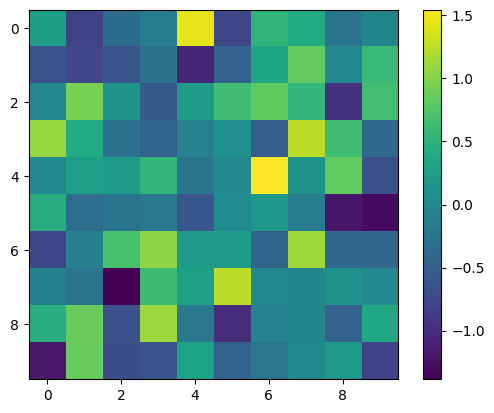

In [8]:
# imshow mat
import matplotlib.pyplot as plt
plt.imshow(mat)
plt.colorbar()

In [9]:
# find the spectral norm of the matrix
spectral_norm = torch.svd(mat).S[0].item()
print(f"Spectral norm of the matrix: {spectral_norm}")

Spectral norm of the matrix: 2.000000476837158


In [54]:
mat = mat / spectral_norm

spectral_norm = torch.svd(mat).S[0].item()
print(f"Spectral norm of the matrix: {spectral_norm}")

Spectral norm of the matrix: 1.0
